# Advanced Sparse Embeddings

### SECTION 1: Setup and Installation

### Install required packages for this tutorial:
 - pymilvus[model]: Milvus vector database client with embedding models
 - datasets: Hugging Face datasets library for climate_fever data
 - nltk: Natural language processing for BM25 tokenization
 - matplotlib: For visualizations (installed separately later)



In [37]:
# Install additional required packages
# !uv pip install datasets  # For loading climate_fever dataset
# !uv pip install -q nltk    # For text tokenization in BM25
# !uv pip install matplotlib seaborn  # For visualizations
# !uv pip install --upgrade 'pymilvus[model]'

In [38]:
# ============================================================
# Import Libraries
# ============================================================

# Milvus vector database imports
import pymilvus
from pymilvus import MilvusClient  # High-level client for simple operations
from pymilvus import (
    utility,                        # Utility functions for Milvus
    FieldSchema,                    # Define schema fields
    CollectionSchema,               # Define collection structure
    DataType,                       # Data types for fields
    Collection,                     # Low-level collection operations
    AnnSearchRequest,               # Create search requests for hybrid search
    RRFRanker,                      # Reciprocal Rank Fusion reranker
    connections,                    # Manage Milvus connections
)

# Sparse embedding imports
from pymilvus.model.sparse.bm25.tokenizers import build_default_analyzer  # BM25 tokenizer
from pymilvus.model.sparse import BM25EmbeddingFunction, SpladeEmbeddingFunction  # Sparse embeddings

from rank_bm25 import BM25Okapi

# Dataset and visualization imports
from datasets import load_dataset  # Hugging Face datasets
import matplotlib.pyplot as plt     # Plotting
import seaborn as sns               # Statistical visualizations
import numpy as np                  # Numerical operations

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## SECTION 2: Dataset and Corpus Preparation

### About the Climate Fever Dataset

We'll use the **climate_fever** dataset, which contains climate-related claims. This dataset is ideal for testing retrieval methods because:

- 📚 Contains factual climate science statements  
- 🔍 Includes both keyword-rich and semantic content
- ✅ Small enough for quick experimentation
- 🌍 Real-world domain (climate science)

### Why Do We Need a Corpus?

For **BM25**, we need to "fit" the model on a corpus to calculate:
- **IDF (Inverse Document Frequency)**: How rare each term is across documents
- **Vocabulary**: Which terms exist in our document collection

This fitting process analyzes the corpus and builds statistics that help BM25 rank documents.

In [39]:
# ============================================================
# Load Dataset and Prepare BM25
# ============================================================

# Load the climate_fever dataset from Hugging Face
# This dataset contains climate-related claims for fact-checking
dataset = load_dataset("climate_fever")

# Extract the text corpus from the test split
# We'll use these claims to "fit" our BM25 model
corpus_text = dataset['test']['claim']

# Display first 5 examples to understand the data
print("Sample claims from the dataset:\n")
for i, claim in enumerate(corpus_text[:5], 1):
    print(f"{i}. {claim}\n")

print(f"\n✅ Loaded {len(corpus_text)} claims from the dataset\n")

# ============================================================
# Build and Fit BM25 Embedding Function
# ============================================================

# Build a default English language analyzer (tokenizer + stemmer)
# This will break text into tokens and normalize them (e.g., "running" → "run")
analyzer = build_default_analyzer(language="en")

# Create BM25 embedding function with the analyzer
# BM25 uses statistical Term Frequency-Inverse Document Frequency (TF-IDF)
bm25_ef = BM25EmbeddingFunction(analyzer)

# FIT the BM25 model on our corpus
# This calculates IDF scores for each term based on corpus statistics
# - Terms that appear in many documents get lower IDF scores
# - Rare terms get higher IDF scores (more distinctive/important)
print("Fitting BM25 on corpus...")
bm25_ef.fit(corpus_text)
print(f"✅ BM25 fitted! Vocabulary size: {bm25_ef.dim} terms")

Sample claims from the dataset:

1. Global warming is driving polar bears toward extinction

2. The sun has gone into ‘lockdown’ which could cause freezing weather, earthquakes and famine, say scientists

3. The polar bear population has been growing.

4. Ironic' study finds more CO2 has slightly cooled the planet

5. Human additions of CO2 are in the margin of error of current measurements and the gradual increase in CO2 is mainly from oceans degassing as the planet slowly emerges from the last ice age.


✅ Loaded 1535 claims from the dataset

Fitting BM25 on corpus...
✅ BM25 fitted! Vocabulary size: 3432 terms


In [40]:
# ============================================================
# Define Sample Documents
# ============================================================

# Our test documents - 5 climate-related statements
# These cover different aspects: predictions, impacts, mechanisms
documents = [
    "Currently, scientists none of these places, which today supply much of the world's food, will be reliable sources of any.",
    "Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.",
    "The jet stream forms a boundary between the cold north and the warmer south, but the lower temperature difference means the winds are now weaker.",
    "Coral becomes stressed and expels the algae, which leave the coral a bleached white color.",
    "The rapid changes in the climate may have profound consequences for humans and other species... Severe drought caused food shortages for millions of people in Ethiopia, with a lack of rainfall resulting in intense and widespread forest fires in Indonesia that belched out a vast quantity of greenhouse gas"
]

print(f"📄 Prepared {len(documents)} documents for embedding\n")

# ============================================================
# Create BM25 Embeddings (Statistical Sparse Vectors)
# ============================================================

print("Creating BM25 embeddings...")
# encode_documents() converts text to sparse vectors using TF-IDF
# Each document becomes a sparse vector where:
# - Keys = term indices in vocabulary
# - Values = BM25 scores (based on TF and IDF)
bm25_docs_embeddings = bm25_ef.encode_documents(documents)

# BM25 dimension = vocabulary size from fitted corpus
print(f"✅ BM25 Sparse Dimension: {bm25_ef.dim} terms")
print(f"   Example vector shape: {list(bm25_docs_embeddings)[0].shape}")
print(f"   (Only non-zero values are stored in sparse format)\n")

# ============================================================
# Create SPLADE Embeddings (Neural Sparse Vectors)
# ============================================================

print("Loading SPLADE model and creating embeddings...")
print("(This may take a moment on first run as it downloads the model)")

# Initialize SPLADE embedding function
# Model: naver/splade-cocondenser-ensembledistil
# - Pre-trained on large corpus
# - Uses BERT-based architecture
# - Produces sparse vectors with learned term importance

# model_name="naver/splade-cocondenser-ensembledistil"

splade_ef = SpladeEmbeddingFunction(
    model_name="naver/splade-v3",
    device="mps"  # Use "cuda" if GPU available for faster encoding
)

# Encode documents with SPLADE
# Unlike BM25, this uses a neural network to:
# 1. Understand context and semantics
# 2. Expand terms (add related vocabulary)
# 3. Learn optimal term weights
splade_docs_embeddings = splade_ef.encode_documents(documents)

# SPLADE dimension = model's vocabulary size (much larger than BM25)
print(f"✅ SPLADE Sparse Dimension: {splade_ef.dim} terms")
print(f"   Example vector shape: {list(splade_docs_embeddings)[0].shape}")
print(f"   (Higher dimension but still mostly zeros - sparse!)\n")

# ============================================================
# Compare the Two Approaches
# ============================================================

print("📊 Comparison:")
print(f"   BM25: {bm25_ef.dim:,} dimensions (corpus vocabulary)")
print(f"   SPLADE: {splade_ef.dim:,} dimensions (model vocabulary)")
print(f"   Ratio: {splade_ef.dim / bm25_ef.dim:.1f}x larger vocabulary for SPLADE")

📄 Prepared 5 documents for embedding

Creating BM25 embeddings...
✅ BM25 Sparse Dimension: 3432 terms
   Example vector shape: (3432,)
   (Only non-zero values are stored in sparse format)

Loading SPLADE model and creating embeddings...
(This may take a moment on first run as it downloads the model)
✅ SPLADE Sparse Dimension: 30522 terms
   Example vector shape: (30522,)
   (Higher dimension but still mostly zeros - sparse!)

📊 Comparison:
   BM25: 3,432 dimensions (corpus vocabulary)
   SPLADE: 30,522 dimensions (model vocabulary)
   Ratio: 8.9x larger vocabulary for SPLADE


In [41]:
# ============================================================
# Connect to Milvus
# ============================================================

print("Connecting to Milvus...")
# Connect to local Milvus instance
# Make sure Milvus is running: docker run -d -p 19530:19530 milvusdb/milvus:latest
connections.connect(
    alias="default",          # Connection name
    host="localhost",         # Milvus server address
    port="19530"              # Default Milvus port
)
print("✅ Connected to Milvus\n")

# ============================================================
# Define Collection Schema
# ============================================================

print("Creating collection schema...")

# Define the fields for our collection
fields = [
    # Primary key field (auto-generated unique ID for each document)
    FieldSchema(
        name="pk", 
        dtype=DataType.VARCHAR,      # String type
        is_primary=True,             # This is the primary key
        auto_id=True,                # Auto-generate IDs
        max_length=100               # Max length for VARCHAR
    ),
    
    # Text field (stores original document content)
    FieldSchema(
        name="text", 
        dtype=DataType.VARCHAR,      # String type
        max_length=512               # Max 512 characters
    ),
    
    # BM25 sparse vector field
    FieldSchema(
        name="bm25_vector", 
        dtype=DataType.SPARSE_FLOAT_VECTOR  # Sparse vector type
        # No dimension specified - inferred from data
    ),
    
    # SPLADE sparse vector field  
    FieldSchema(
        name="splade_vector", 
        dtype=DataType.SPARSE_FLOAT_VECTOR  # Sparse vector type
        # No dimension specified - inferred from data
    ),
]

# Create the schema
schema = CollectionSchema(
    fields=fields, 
    description="BM25 and SPLADE sparse embeddings for climate documents"
)

# Create the collection (like a table in SQL)
col = Collection("bm25_splade_demo", schema)
print(f"✅ Created collection: bm25_splade_demo\n")

# ============================================================
# Create Indexes for Fast Search
# ============================================================

print("Creating indexes...")

# Sparse inverted index configuration
# SPARSE_INVERTED_INDEX is optimized for sparse vectors
# IP (Inner Product) is the similarity metric for sparse vectors
sparse_index = {
    "index_type": "SPARSE_INVERTED_INDEX",  # Index type for sparse vectors
    "metric_type": "IP"                      # Inner Product similarity
}

# Create index for BM25 vectors
col.create_index("bm25_vector", sparse_index)
print("✅ Created index for bm25_vector")

# Create index for SPLADE vectors
col.create_index("splade_vector", sparse_index)
print("✅ Created index for splade_vector\n")

# ============================================================
# Helper Function: Convert Sparse Matrix to Dict Format
# ============================================================

def sparse_to_dict(sparse_matrix):
    """
    Convert scipy sparse matrix to dictionary format required by Milvus.
    
    Milvus expects sparse vectors as: {index: value, index: value, ...}
    where index is the term position and value is the weight.
    
    Args:
        sparse_matrix: scipy.sparse matrix or dict
        
    Returns:
        dict: {index: value} format
    """
    if hasattr(sparse_matrix, 'tocoo'):
        # It's a scipy sparse matrix - convert to COO format
        coo = sparse_matrix.tocoo()
        # coo.col contains column indices (term positions)
        # coo.data contains the values (weights)
        return {int(idx): float(val) for idx, val in zip(coo.col, coo.data)}
    # Already in dict format
    return sparse_matrix

# ============================================================
# Convert and Insert Embeddings
# ============================================================

print("Converting embeddings to Milvus format...")

# Convert scipy sparse matrices to dict format
# BM25 and SPLADE encode_documents() return scipy sparse matrices
# We need to convert them to {index: value} dict format
bm25_docs_embeddings_dict = [sparse_to_dict(vec) for vec in bm25_docs_embeddings]
splade_docs_embeddings_dict = [sparse_to_dict(vec) for vec in splade_docs_embeddings]

print(f"✅ Converted {len(documents)} BM25 embeddings")
print(f"✅ Converted {len(documents)} SPLADE embeddings\n")

print("Inserting data into Milvus...")

# Insert data into collection
# entities is a list of field values: [text_list, bm25_list, splade_list]
# Milvus will align them row-by-row to create documents
entities = [
    documents,                      # Text field
    bm25_docs_embeddings_dict,     # BM25 vectors
    splade_docs_embeddings_dict    # SPLADE vectors
]

# Insert and flush to disk
insert_result = col.insert(entities)
col.flush()

print(f"✅ Inserted {len(documents)} documents into Milvus")
print(f"   Collection now contains {col.num_entities} entities\n")

print("="*60)
print("🎉 Database setup complete!")
print("="*60)

Connecting to Milvus...
✅ Connected to Milvus

Creating collection schema...
✅ Created collection: bm25_splade_demo

Creating indexes...
✅ Created index for bm25_vector
✅ Created index for splade_vector

Converting embeddings to Milvus format...
✅ Converted 5 BM25 embeddings
✅ Converted 5 SPLADE embeddings

Inserting data into Milvus...
✅ Inserted 5 documents into Milvus
   Collection now contains 5 entities

🎉 Database setup complete!


In [42]:
# ============================================================
# Setup Client and Load Collection
# ============================================================

# Create a high-level MilvusClient for search operations
client = MilvusClient(uri="http://localhost:19530")

# Load the collection into memory for searching
collection = Collection("bm25_splade_demo")
collection.load()
print("✅ Collection loaded and ready for search\n")

# ============================================================
# Helper Functions for Search and Comparison
# ============================================================

def perform_search(query, method="bm25", limit=3):
    """
    Perform search using specified method.
    
    Args:
        query: Search query string
        method: "bm25", "splade", or "hybrid"
        limit: Number of results to return
        
    Returns:
        Search results
    """
    if method == "bm25":
        # Encode query with BM25
        query_emb = bm25_ef.encode_queries([query])
        # Search using BM25 vectors
        results = client.search(
            collection_name="bm25_splade_demo",
            data=[sparse_to_dict(query_emb[0])],
            anns_field="bm25_vector",
            limit=limit,
            output_fields=["text"]
        )
        return results
        
    elif method == "splade":
        # Encode query with SPLADE
        query_emb = splade_ef.encode_queries([query])
        # Search using SPLADE vectors
        results = client.search(
            collection_name="bm25_splade_demo",
            data=[sparse_to_dict(query_emb[0])],
            anns_field="splade_vector",
            limit=limit,
            output_fields=["text"]
        )
        return results
        
    elif method == "hybrid":
        # Encode query with both methods
        bm25_query_emb = bm25_ef.encode_queries([query])
        splade_query_emb = splade_ef.encode_queries([query])
        
        # Create search requests for both methods
        req1 = AnnSearchRequest(
            data=[sparse_to_dict(bm25_query_emb[0])],
            anns_field="bm25_vector",
            param={"metric_type": "IP"},
            limit=limit
        )
        req2 = AnnSearchRequest(
            data=[sparse_to_dict(splade_query_emb[0])],
            anns_field="splade_vector",
            param={"metric_type": "IP"},
            limit=limit
        )
        
        # Hybrid search with RRF (Reciprocal Rank Fusion)
        results = collection.hybrid_search(
            [req1, req2],
            rerank=RRFRanker(k=60),  # k=60 is default smoothing parameter
            limit=limit,
            output_fields=["text"]
        )
        return results

def display_results(results, method_name):
    """
    Display search results in a formatted way.
    
    Args:
        results: Search results from Milvus
        method_name: Name of the method (for display)
    """
    print(f"\n{'='*80}")
    print(f"  {method_name} RESULTS")
    print(f"{'='*80}")
    
    for i, hit in enumerate(results[0], 1):
        score = hit['distance']
        text = hit['entity']['text'] if 'entity' in hit else hit.get('text', '')
        
        print(f"\n[Rank {i}] Score: {score:.4f}")
        print(f"  {text}")
    
    print(f"\n{'='*80}\n")

def compare_all_methods(query, limit=3):
    """
    Run all three search methods and display results side-by-side.
    
    Args:
        query: Search query string
        limit: Number of results per method
    """
    print(f"\n{'#'*80}")
    print(f"  QUERY: {query}")
    print(f"{'#'*80}\n")
    
    # Perform searches
    bm25_results = perform_search(query, "bm25", limit)
    splade_results = perform_search(query, "splade", limit)
    hybrid_results = perform_search(query, "hybrid", limit)
    
    # Display results
    display_results(bm25_results, "🔍 BM25 (Statistical)")
    display_results(splade_results, "🧠 SPLADE (Neural)")
    display_results(hybrid_results, "🔄 HYBRID (RRF)")
    
    return bm25_results, splade_results, hybrid_results

print("✅ Helper functions defined and ready to use!")

✅ Collection loaded and ready for search

✅ Helper functions defined and ready to use!


In [43]:
# Query 1: Semantic question with synonym variations
query1 = "What do researchers say about global warming?"

# Compare all three methods
q1_bm25, q1_splade, q1_hybrid = compare_all_methods(query1, limit=3)


################################################################################
  QUERY: What do researchers say about global warming?
################################################################################


  🔍 BM25 (Statistical) RESULTS

[Rank 1] Score: 8.4361
  Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.



  🧠 SPLADE (Neural) RESULTS

[Rank 1] Score: 15.9788
  Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.

[Rank 2] Score: 10.1804
  The rapid changes in the climate may have profound consequences for humans and other species... Severe drought caused food shortages for millions of people in Ethiopia, with a lack of rainfall resulting in intense and widespread forest fires in Ind

## Query 1: Semantic Question (Natural Language)

This query uses natural language and **different terminology** than our documents:
- Uses "researchers" (documents say "scientists")  
- Uses "global warming" (some documents say "climate")
- Natural question structure

**Prediction**: SPLADE should perform better due to semantic understanding!

## 🎓 What You Learned

Congratulations! You now understand:

✅ **Sparse Retrieval Fundamentals**
- How sparse vectors differ from dense vectors
- Memory efficiency and interpretability advantages

✅ **BM25 (Statistical Method)**
- TF-IDF based keyword matching
- Fast and interpretable
- Best for exact keyword searches

✅ **SPLADE (Neural Method)**
- Learned term importance with BERT
- Semantic understanding and query expansion
- Best for natural language queries

✅ **Hybrid Search with RRF**
- Combining multiple retrieval methods
- Reciprocal Rank Fusion algorithm
- Best overall performance for production systems

✅ **Score Interpretation**
- Why scores differ across methods
- Focus on rankings, not raw scores
- Normalization for fair comparison

✅ **Practical Decision Making**
- When to use each method
- Trade-offs between speed, accuracy, and complexity

---

## 🚀 Next Steps

### Experiment Further:
1. **Try your own queries** - Test with different query types
2. **Add more documents** - Scale up to larger document collections
3. **Tune parameters** - Experiment with RRF k parameter, BM25 parameters
4. **Try SPLADE v3** - Upgrade to `naver/splade-v3` for better performance

### Build on This:
1. **Integrate with LLMs** - Use retrieved documents as context for GPT/Claude
2. **Add reranking** - Use cross-encoders for second-stage reranking
3. **Evaluate systematically** - Measure precision, recall, NDCG metrics
4. **Production deployment** - Scale to millions of documents with Milvus clustering

### Learn More:
- 📚 [Milvus Documentation](https://milvus.io/docs)
- 📖 [BM25 Paper](https://en.wikipedia.org/wiki/Okapi_BM25)
- 🧠 [SPLADE Paper](https://arxiv.org/abs/2109.10086)
- 🔄 [RRF Paper](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf)

---

## 📝 Key Takeaways

1. **No single method is always best** - Choose based on your use case
2. **Hybrid search often wins** - Combines keyword precision with semantic understanding
3. **Score comparison requires normalization** - Different scales across methods
4. **Sparse vectors are powerful** - Efficient, interpretable, and effective

---

## 🙏 Thank You!

You've completed this tutorial on sparse retrieval with BM25, SPLADE, and hybrid search. Happy building!

For questions or feedback, refer to the [advanced-rag-tutorials](https://github.com) repository.

In [44]:
#Uncomment to drop the collection and clean up
# utility.drop_collection("bm25_splade_demo")
# print("✅ Collection dropped successfully")

# SECTION 9: Cleanup and Next Steps

## Cleanup (Optional)

If you want to delete the collection and start fresh, run the cell below.

**⚠️ Warning**: This will permanently delete all data in the `bm25_splade_demo` collection!

# SECTION 8: When to Use Each Method

## Decision Guide

Choose your retrieval method based on your **query characteristics** and **requirements**:

---

## 🔍 Use BM25 When...

### ✅ Best For:
- **Exact keyword matching** (e.g., searching for specific terms, IDs, codes)
- **Short, keyword-heavy queries** (e.g., "climate change emissions")
- **Speed is critical** (BM25 is fastest)
- **No ML model available** (works without pre-trained models)
- **Interpretable results** needed (can see exactly which terms matched)

### ❌ Not Ideal For:
- Queries with synonyms (e.g., "car" won't match "automobile")
- Natural language questions
- Queries requiring semantic understanding

### Example Use Cases:
- 📚 Document search by keywords
- 🔎 Log file searching
- 📋 Product catalog search with exact attributes
- 💼 Legal document retrieval with specific terminology

---

## 🧠 Use SPLADE When...

### ✅ Best For:
- **Natural language queries** (e.g., "What causes global warming?")
- **Semantic similarity** (matches "car" with "automobile")
- **Complex questions** requiring context understanding
- **Synonym handling** (different words, same meaning)
- **Better recall** (finds relevant docs even with different wording)

### ❌ Not Ideal For:
- Exact keyword-only searches
- When speed is critical (slower than BM25)
- Limited computational resources (requires neural model)

### Example Use Cases:
- ❓ Question answering systems
- 🔬 Scientific paper search
- 💬 Customer support chatbots
- 📰 News article retrieval

---

## 🔄 Use Hybrid Search (RRF) When...

### ✅ Best For:
- **Production RAG systems** (combines strengths of both)
- **Unknown query types** (works well across different query styles)
- **Best overall performance** (often outperforms individual methods)
- **Robust retrieval** (balances keyword and semantic matching)

### ❌ Not Ideal For:
- When speed is absolutely critical (requires running both methods)
- Very simple keyword searches (BM25 alone may suffice)

### Example Use Cases:
- 🤖 Production chatbots and assistants
- 🔍 General-purpose search engines
- 📚 Knowledge base retrieval
- 💼 Enterprise document search

---

## Performance Summary Table

| Method | Speed | Accuracy (Keywords) | Accuracy (Semantic) | Complexity | Best Query Type |
|--------|-------|--------------------|--------------------|------------|----------------|
| **BM25** | ⚡ Fastest | ⭐⭐⭐ Excellent | ⭐ Poor | 🟢 Simple | Short, keyword-heavy |
| **SPLADE** | 🐢 Slower | ⭐⭐ Good | ⭐⭐⭐ Excellent | 🔴 Complex | Natural language |
| **Hybrid (RRF)** | 🐌 Slowest | ⭐⭐⭐ Excellent | ⭐⭐⭐ Excellent | 🟡 Medium | All types |

---

## Recommendation

For **most production RAG systems**, use **Hybrid Search with RRF** as it:
- Combines keyword precision with semantic understanding
- Works well across diverse query types
- Provides robust, high-quality retrieval

Only optimize to single-method if you have specific constraints (speed, resources) or highly specialized query patterns.

# SECTION 7: Understanding Scores and Metrics

## Why Scores Differ Between Methods

Each retrieval method uses a **different scoring mechanism**, which means:
- ❌ Scores are **NOT directly comparable** across methods
- ✅ **Rankings** (which documents are top-ranked) are what matter
- 📊 Score **magnitudes** vary based on the underlying algorithm

## Score Breakdown by Method

### 1. BM25 Scores

**What it measures**: Statistical term matching using TF-IDF

**Score formula**: `BM25(q,d) = Σ IDF(term) × (TF(term) × (k+1)) / (TF(term) + k × (1 - b + b × |d|/avgdl))`

**Characteristics**:
- **Range**: Unbounded (theoretically 0 to ∞)
- **Typical range**: 0-30 for most queries
- **Higher score**: More keyword overlap
- **Depends on**:
  - Term frequency in document
  - Term rarity across corpus (IDF)
  - Document length normalization

**Example**: Query "scientists climate" matching doc with both terms scores ~7.5

### 2. SPLADE Scores

**What it measures**: Neural learned term importance

**How it works**: BERT-based model assigns importance weights to terms, including expanded vocabulary

**Characteristics**:
- **Range**: Unbounded (0 to ∞)
- **Typical range**: 0-50+
- **Why higher**: Neural networks learn larger magnitude weights
- **Depends on**:
  - Learned term importance from neural network
  - Query expansion (adds related terms)
  - Contextual understanding

**Example**: Same query scores ~16.7 because SPLADE adds semantic similarity beyond exact matches

### 3. Hybrid RRF Scores

**What it measures**: Combined ranking from both methods

**Score formula**: `RRF_score = Σ 1 / (k + rank_i)` where k=60 (default)

**Characteristics**:
- **Range**: (0, 1/k] ≈ (0, 0.0167] for k=60
- **Why small**: Normalized by rank position, not raw similarity
- **Depends on**:
  - Rankings from BM25 and SPLADE
  - Smoothing parameter k (default=60)

**Example**:
- Doc ranked #1 in both: 1/(60+1) + 1/(60+1) = 0.0328
- Doc ranked #1 and #3: 1/(60+1) + 1/(60+3) ≈ 0.0322

## Key Takeaways

1. **Don't compare raw scores** across methods - they use different scales
2. **Focus on rankings** - which documents are top-ranked?
3. **Normalize for visualization** - makes comparison easier
4. **Hybrid RRF** balances both methods' rankings, not their scores

In [45]:
# ============================================================
# Visualization Helper Functions
# ============================================================

def normalize_scores(scores):
    """
    Normalize scores to 0-1 range for fair comparison.
    
    Args:
        scores: List of scores
        
    Returns:
        List of normalized scores (0-1)
    """
    if not scores or len(scores) == 0:
        return []
    max_score = max(scores)
    min_score = min(scores)
    range_score = max_score - min_score if max_score != min_score else 1
    return [(s - min_score) / range_score for s in scores]

def visualize_score_comparison(bm25_res, splade_res, hybrid_res, query_name, normalize=True):
    """
    Create bar chart comparing scores across all three methods.
    
    Args:
        bm25_res, splade_res, hybrid_res: Search results from Milvus
        query_name: Name/description of the query
        normalize: Whether to normalize scores to 0-1 range
    """
    # Extract scores from results
    bm25_scores = [hit['distance'] for hit in bm25_res[0]]
    splade_scores = [hit['distance'] for hit in splade_res[0]]
    hybrid_scores = [hit['distance'] for hit in hybrid_res[0]]
    
    # Normalize if requested
    if normalize:
        bm25_scores = normalize_scores(bm25_scores)
        splade_scores = normalize_scores(splade_scores)
        hybrid_scores = normalize_scores(hybrid_scores)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(bm25_scores))
    width = 0.25
    
    # Create bars
    bars1 = ax.bar(x - width, bm25_scores, width, label='BM25', alpha=0.8, color='#3498db')
    bars2 = ax.bar(x, splade_scores, width, label='SPLADE', alpha=0.8, color='#e74c3c')
    bars3 = ax.bar(x + width, hybrid_scores, width, label='Hybrid (RRF)', alpha=0.8, color='#2ecc71')
    
    # Customize plot
    ax.set_xlabel('Rank Position', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score (Normalized)' if normalize else 'Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Score Comparison: {query_name}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Rank {i+1}' for i in range(len(bm25_scores))])
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


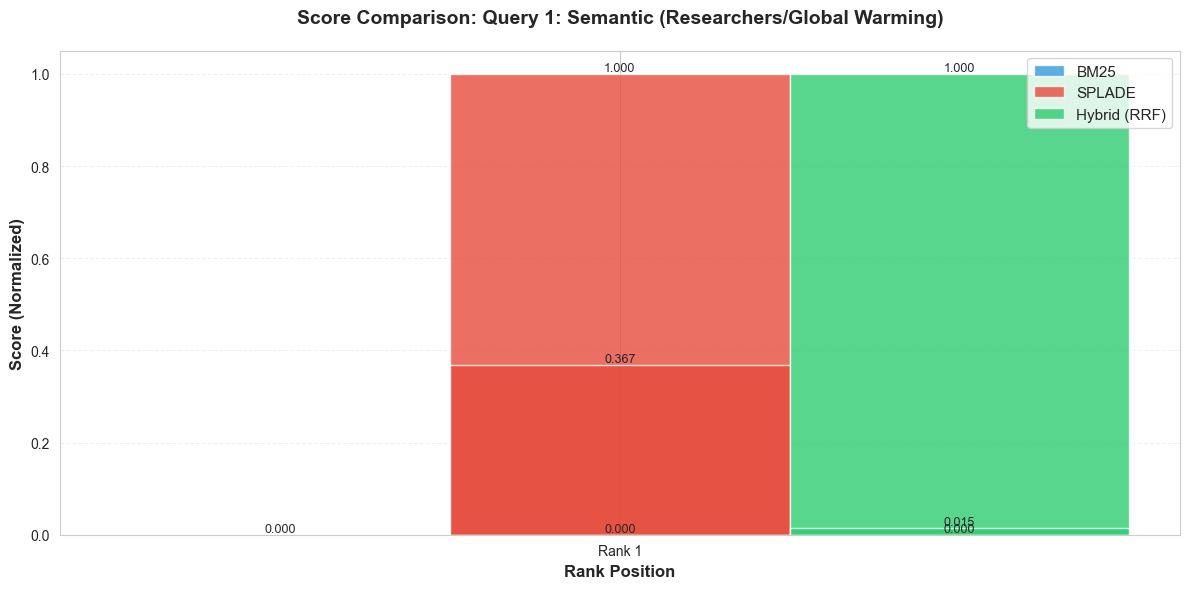

In [46]:
# Visualize Query 1 results
visualize_score_comparison(q1_bm25, q1_splade, q1_hybrid, "Query 1: Semantic (Researchers/Global Warming)", normalize=True)

# SECTION 6: Visualizing Score Comparisons

## Why Visualize?

Visualizations help us:
- 📊 **Compare** scores across methods at a glance
- 🔍 **Identify** which method ranks documents highest
- 📈 **Understand** relative differences between methods
- 💡 **Learn** which method works best for different query types

## Normalization

Since BM25, SPLADE, and RRF use different score scales, we'll **normalize** scores to 0-1 range for fair visual comparison.

## Query 3: Complex Multi-Faceted

This query is complex with **multiple concepts**:
- Long, detailed question
- Multiple aspects (ecosystems AND populations)
- Requires both keyword and semantic understanding

**Prediction**: Hybrid search should perform best by combining both methods!

In [47]:
# Query 3: Complex multi-faceted query
query3 = "How does climate change affect ecosystems and human populations?"

# Compare all three methods
q3_bm25, q3_splade, q3_hybrid = compare_all_methods(query3, limit=3)


################################################################################
  QUERY: How does climate change affect ecosystems and human populations?
################################################################################


  🔍 BM25 (Statistical) RESULTS

[Rank 1] Score: 3.8027
  The rapid changes in the climate may have profound consequences for humans and other species... Severe drought caused food shortages for millions of people in Ethiopia, with a lack of rainfall resulting in intense and widespread forest fires in Indonesia that belched out a vast quantity of greenhouse gas

[Rank 2] Score: 3.2851
  Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.



  🧠 SPLADE (Neural) RESULTS

[Rank 1] Score: 18.7407
  The rapid changes in the climate may have profound consequences for humans and other species... Severe drought caused f

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

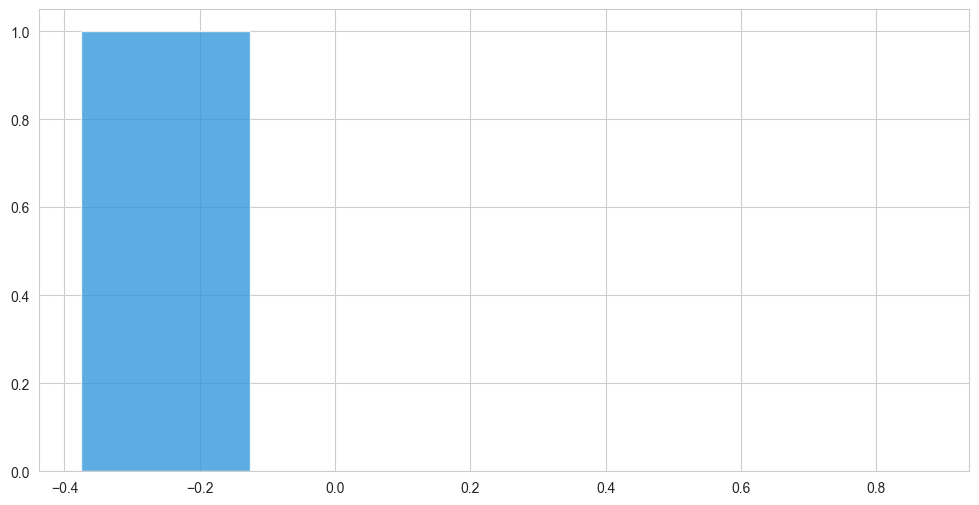

In [51]:
# Visualize Query 3 results
visualize_score_comparison(q3_bm25, q3_splade, q3_hybrid, "Query 3: Complex (Ecosystems/Populations)", normalize=True)

## Query 2: Keyword-Heavy (Short, Specific)

This query uses **exact keywords** that appear in documents:
- Short and specific
- Direct term matches expected
- No synonyms or complex language

**Prediction**: BM25 should excel at exact keyword matching!

In [49]:
# Query 2: Keyword-heavy query with exact terms
query2 = "scientists climate emissions"

# Compare all three methods
q2_bm25, q2_splade, q2_hybrid = compare_all_methods(query2, limit=3)


################################################################################
  QUERY: scientists climate emissions
################################################################################


  🔍 BM25 (Statistical) RESULTS

[Rank 1] Score: 5.3900
  Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.

[Rank 2] Score: 2.6314
  Currently, scientists none of these places, which today supply much of the world's food, will be reliable sources of any.

[Rank 3] Score: 0.8811
  The rapid changes in the climate may have profound consequences for humans and other species... Severe drought caused food shortages for millions of people in Ethiopia, with a lack of rainfall resulting in intense and widespread forest fires in Indonesia that belched out a vast quantity of greenhouse gas



  🧠 SPLADE (Neural) RESULTS

[Rank 1] Score: 20.1579
  Over th

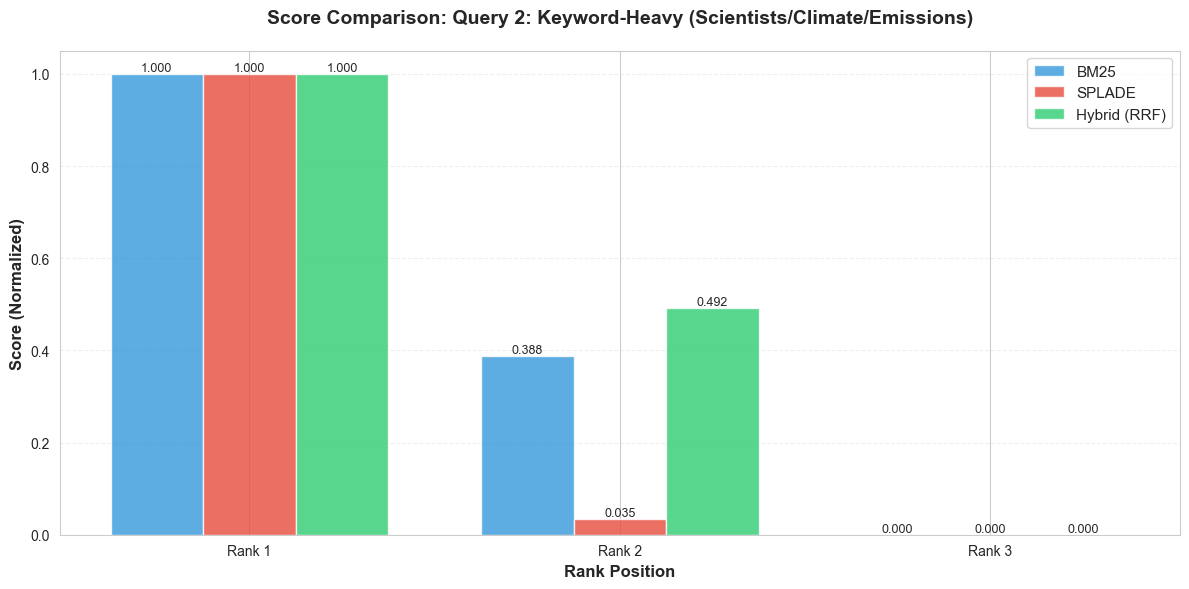

In [50]:
# Visualize Query 2 results
visualize_score_comparison(q2_bm25, q2_splade, q2_hybrid, "Query 2: Keyword-Heavy (Scientists/Climate/Emissions)", normalize=True)

In [ ]:
def get_relevant_text(query_embeddings, anns_field):

    res = client.search(
        collection_name="bm25_splade_demo",
        data=query_embeddings[0],
        anns_field=anns_field,
        limit=1,
        search_params={"metric_type": "IP", "params": {}},
        output_fields =["text"]
    )
    print(res)

# Set up a Milvus client
client = MilvusClient(
    uri="http://localhost:19530"
)

collection = Collection("bm25_splade_demo")      # Get an existing collection.
collection.load()

queries = ["What do scientists say about climate?"]
bm25_query_embeddings = bm25_ef.encode_queries(queries)

In [ ]:
splade_query_embeddings = splade_ef.encode_queries(queries)
splade_results = client.search(
    collection_name="bm25_splade_demo",
    data=[sparse_to_dict(splade_query_embeddings[0])],
    anns_field="splade_vector",
    limit=3,
      output_fields=["text"]
  )

  ### Score Breakdown

  1. BM25 Scores (7.6991, 2.6314, 0.8811)

  - Metric: Inner Product (IP) of sparse BM25 vectors
  - Range: Unbounded (theoretically 0 to ∞)
  - Typical Range: 0-30 for most queries
  - Interpretation: Based on term frequency (TF) × inverse document frequency (IDF)
    - Higher score = more relevant
    - Score depends on: query length, document length, term overlap

  2. SPLADE Scores (8.7048, 7.1504, 6.4090)

  - Metric: Inner Product (IP) of learned sparse vectors
  - Range: Unbounded (0 to ∞)
  - Why Higher: SPLADE learns term importance weights through neural networks
    - Terms get weighted importance scores (not just TF-IDF)
    - Query expansion (adds related terms)
    - Can produce higher magnitude vectors
  - Interpretation: Higher absolute values because SPLADE's learned weights tend to be larger than BM25's statistical weights

  3. Hybrid RRF Scores (0.0328, 0.0320, 0.0320)

  - Metric: Reciprocal Rank Fusion
  - Range: (0, 1/k] where k=60 by default
  - Formula: score = Σ(1 / (k + rank_i))
    - For rank 1: 1/(60+1) ≈ 0.0164
    - For rank 2: 1/(60+2) ≈ 0.0161
    - Summed across both retrieval methods
  - Why Small: RRF normalizes by rank position, not raw scores
  - Interpretation: These scores combine rankings from both methods